# Index Funds with Mixed-Integer-Programming

We will analyze daily price data for stocks in the Dow Jones index and then try to build an accurate index fund using a small numbers of stocks therein.

Similar material was already used in a presentation at PyData Berlin 2017. See the ["Tour of popular packages" notebook](http://nbviewer.jupyter.org/github/daveh19/pydataberlin2017/blob/master/notebooks/02%20Tour%20of%20popular%20packages.ipynb). Back then, we worked with Julia 0.6 and used the packages `DataFrames`, `Plots` and `JuMP`. Now, we work with Julia 1.0 and use packages from the `Queryverse` and `IndexedTables` for data prep and visualization.

## Loading the Data

In [1]:
using Queryverse
using IndexedTables: ndsparse

In [2]:
price = load("dowjones2016.csv") |> ndsparse
price |> @take(3)

3x3 query result
Date       │ Symbol │ Price 
───────────┼────────┼───────
2016-01-04 │ AAPL   │ 105.35
2016-01-04 │ AXP    │ 67.59 
2016-01-04 │ BA     │ 140.5

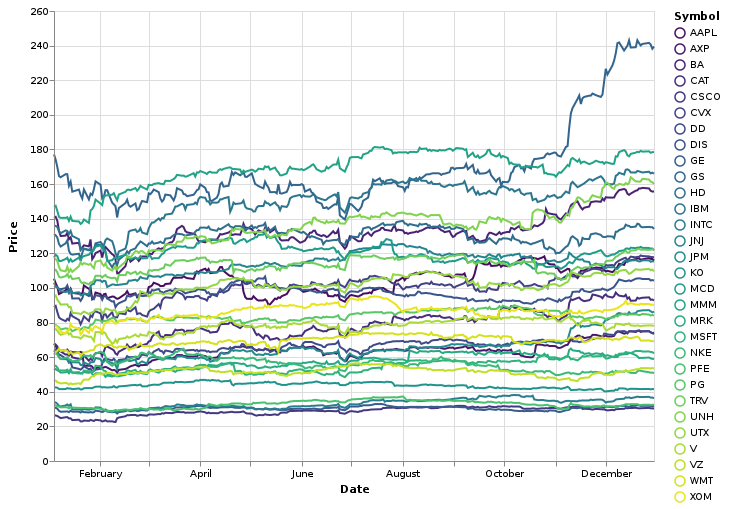

In [45]:
price |> @vlplot(:line, x=:Date, y=:Price, color={"Symbol:o", scale={scheme="viridis"}},
                 width=600, height=450)

## Computing the Dow Jones Index

The Dow Jones index is computed from the prices of some 30 stocks, as a weighted average, where the weight is itself defined through the price of the stock.

We will compute the average price of each stock over the days of the year 2016. Then we will normalize these values by dividing through the total of the average prices. The normalized weights are then multiplied to the daily prices to get the daily value of the index.

In [4]:
using Statistics: mean

In [5]:
avgprice = price |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), AvgPrice=mean(_.Price)})
avgprice |> @take(4)

4x2 query result
Symbol │ AvgPrice
───────┼─────────
AAPL   │ 104.604 
AXP    │ 63.7933 
BA     │ 133.112 
CAT    │ 78.698

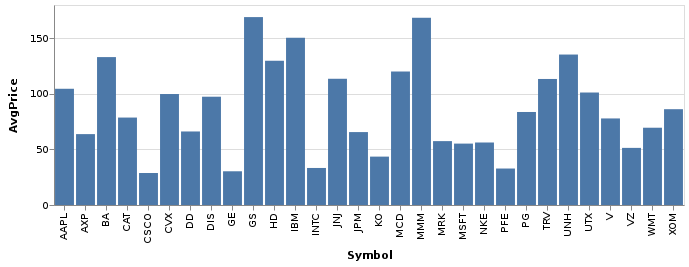

In [6]:
avgprice |> @vlplot(:bar, x=:Symbol, y=:AvgPrice)

In [7]:
totalavg = avgprice |> @map(_.AvgPrice) |> sum

2617.739246769842

In [8]:
weight = avgprice |> @map({Symbol=_.Symbol, Weight=_.AvgPrice / totalavg}) |> ndsparse
weight |> @take(4)

4x2 query result
Symbol │ Weight   
───────┼──────────
AAPL   │ 0.0399597
AXP    │ 0.0243696
BA     │ 0.0508498
CAT    │ 0.0300634

In [9]:
dowjones = price |> 
    @join(weight, _.Symbol, _.Symbol, {_.Date, _.Symbol, Contrib=_.Price * __.Weight}) |>
    @groupby(_.Date) |>
    @map({Date=key(_), Value=sum(_.Contrib)}) |> ndsparse
dowjones |> @take(4)

4x2 query result
Date       │ Value  
───────────┼────────
2016-01-04 │ 100.573
2016-01-05 │ 100.511
2016-01-06 │ 99.0142
2016-01-07 │ 96.606

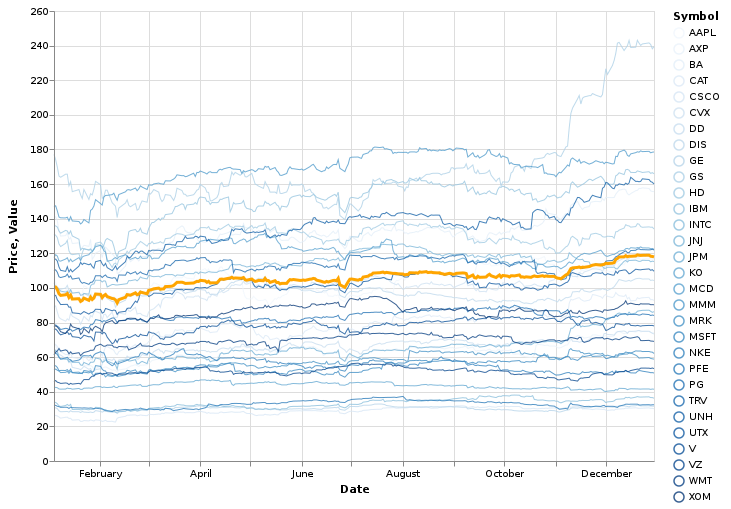

In [46]:
@vlplot(width=600, height=450) +
@vlplot(mark={:line, strokeWidth=1, opacity=0.8}, data=price, x=:Date, y=:Price,
        color={"Symbol:n", scale={scheme="blues"}}) +
@vlplot(mark={:line, strokeWidth=3, color=:orange}, data=dowjones, x=:Date, y=:Value)

# Model for Linear Fit

Let us start with an optimization model similar to an ordinary linear regression, but using the l1-norm, which is readily formulated as a linear program. In compact vector form, this reads

\begin{align*}
\text{minimize} \quad   & \lVert w^T P - I \rVert_1 \\
\text{subject to} \quad & w \ge 0
\end{align*}

where $P$ stands for the prices of the individual st, $I$ for our index (the target) and $w$ for the weights we use in our fund. We only allow non-negative weights for use in the portfolio.

We can use a standard linear programming trick and introduce auxiliary variables for the positive and negative parts inside the absolute values and minimize their sum. This is formulated using JuMP:

In [11]:
using JuMP
using SCIP

In [12]:
dates = unique(price.index.columns.Date)
symbols = unique(price.index.columns.Symbol)

length(dates), length(symbols)

(252, 30)

In [25]:
function solve_index_linear()
    m = Model(solver=SCIPSolver("display/verblevel", 2))
    
    @variable(m, weight[symbols] >= 0)
    @variable(m, posdev[dates] >= 0)
    @variable(m, negdev[dates] >= 0)
    
    for d in dates
        @constraint(m, sum(weight[s]*price[d,s][1] for s in symbols) - dowjones[d][1] == posdev[d] - negdev[d])
    end
    
    @objective(m, :Min, sum(posdev[d] + negdev[d] for d in dates))
    
    status = solve(m)
    return (
        status = status,
        weight = getvalue(weight),
        posdev = getvalue(posdev),
        negdev = getvalue(negdev),
    )
end

solve_index_linear (generic function with 1 method)

In [26]:
sol = solve_index_linear()
sol.status

:Optimal

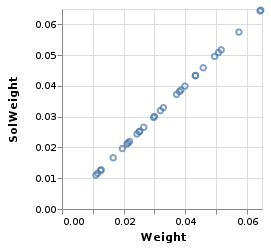

In [27]:
solweight = [(Symbol=s, SolWeight=sol.weight[s]) for s in symbols]
weight |>
    @join(solweight, _.Symbol, _.Symbol, {_.Symbol, _.Weight, __.SolWeight}) |>
    @vlplot(:point, x=:Weight, y=:SolWeight)

# Model with Sparsity Constraint

In [28]:
bigM = 1 / minimum(weight.data.columns[1])

90.926297738811

In [29]:
function solve_index_sparse(nstocks)
    m = Model(solver=SCIPSolver("display/verblevel", 2, "limits/gap", 0.05))
    
    @variable(m, active[symbols], Bin)
    @variable(m, weight[symbols] >= 0)
    @variable(m, posdev[dates] >= 0)
    @variable(m, negdev[dates] >= 0)
    
    for d in dates
        @constraint(m, sum(weight[s]*price[d,s][1] for s in symbols) - dowjones[d][1] == posdev[d] - negdev[d])
    end
    
    for s in symbols
        @constraint(m, weight[s] <= bigM*active[s])
    end
    
    @constraint(m, sum(active[s] for s in symbols) <= nstocks)
    
    @objective(m, :Min, sum(posdev[d] + negdev[d] for d in dates))
    
    status = solve(m, suppress_warnings=true)
    return (
        status = status,
        objval = getobjective(m),
        active = getvalue(active),
        weight = getvalue(weight),
        posdev = getvalue(posdev),
        negdev = getvalue(negdev),
    )
end

solve_index_sparse (generic function with 1 method)

In [30]:
sols = [solve_index_sparse(n) for n in 1:4];

In [31]:
solweight = [(NStocks=n, Symbol=s, SolWeight=sols[n].weight[s]) for n in 1:4 for s in symbols] |>
            @filter(_.SolWeight > 0.0)
solweight |> @take(3)

3x3 query result
NStocks │ Symbol │ SolWeight
────────┼────────┼──────────
1       │ UTX    │ 1.0377   
2       │ BA     │ 0.400165 
2       │ MMM    │ 0.308928

In [32]:
indices = price |>
    @join(solweight, _.Symbol, _.Symbol, {__.NStocks, _.Date, _.Symbol, Contrib=_.Price * __.SolWeight}) |>
    @groupby({_.NStocks, _.Date}) |>
    @map({NStocks=_.NStocks[1], Date=_.Date[1], Value=sum(_.Contrib)}) |> ndsparse
indices |> @take(3)

3x3 query result
NStocks │ Date       │ Value  
────────┼────────────┼────────
1       │ 2016-01-04 │ 99.1729
1       │ 2016-01-05 │ 99.3285
1       │ 2016-01-06 │ 96.6305

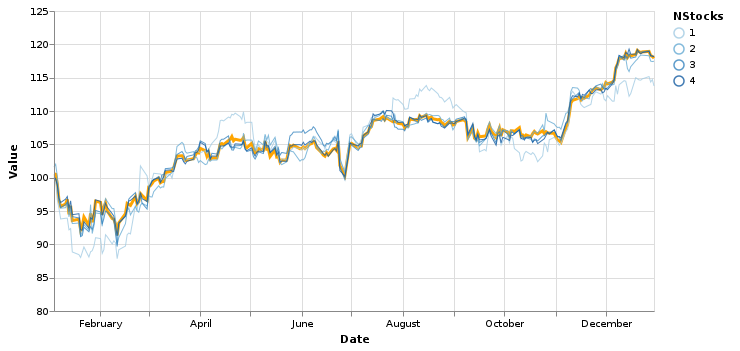

In [47]:
@vlplot(width=600, height=300) +
@vlplot(mark={:line, color=:orange, strokeWidth=3},
        data=dowjones, x=:Date, y={:Value, scale={domain=[80, 125]}}) +
@vlplot(mark={:line, strokeWidth=1, opacity=0.8},
        data=indices, x=:Date, y=:Value, color="NStocks:o")

# Computing Returns

In [34]:
prevdates = (Date=dates[2:end], PrevDate=dates[1:end-1])
prevdates |> @take(3)

3x2 query result
Date       │ PrevDate  
───────────┼───────────
2016-01-05 │ 2016-01-04
2016-01-06 │ 2016-01-05
2016-01-07 │ 2016-01-06

In [35]:
price[:, "AAPL"] |> @take(3)

returns = prevdates |>
    @join(price, _.Date, _.Date, {_.Date, _.PrevDate, __.Symbol, __.Price}) |>
    @join(price, {Date=_.PrevDate, _.Symbol}, {_.Date, _.Symbol},
                 {__.Symbol, _.Date, Return=_.Price / __.Price - 1.0}) |>
    ndsparse
returns |> @take(3)

3x3 query result
Symbol │ Date       │ Return    
───────┼────────────┼───────────
AAPL   │ 2016-01-05 │ -0.0250593
AAPL   │ 2016-01-06 │ -0.0195697
AAPL   │ 2016-01-07 │ -0.0422046

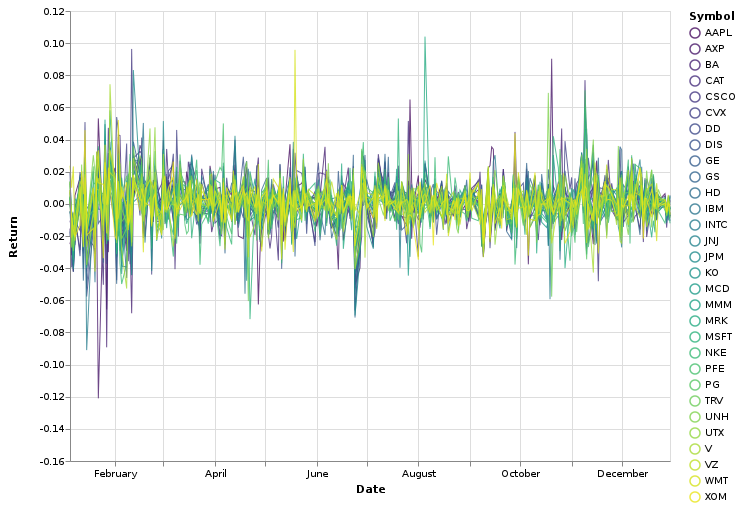

In [43]:
returns |>
    @vlplot(mark={:line, opacity=0.8, strokeWidth=1}, width=600, height=450,
            x=:Date, y=:Return, color={"Symbol:o", scale={scheme="viridis"}})

# Analyzing Correlation

In [73]:
returnagg = returns |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), MeanReturn=mean(_.Return)}) |>
    @join(returns, _.Symbol, _.Symbol,
          {_.Symbol, __.Date, _.MeanReturn, ShiftedSqr=(__.Return - _.MeanReturn)^2}) |>
    @groupby(_.Symbol) |>
    @map({Symbol=key(_), MeanReturn=_.MeanReturn[1],
          StdDevReturn=sqrt(sum(_.ShiftedSqr)/(length(_) - 1))})
returnagg |> @take(3)

3x3 query result
Symbol │ MeanReturn  │ StdDevReturn
───────┼─────────────┼─────────────
AAPL   │ 0.000486129 │ 0.0147511   
AXP    │ 0.000486066 │ 0.0154382   
BA     │ 0.00052439  │ 0.0151332

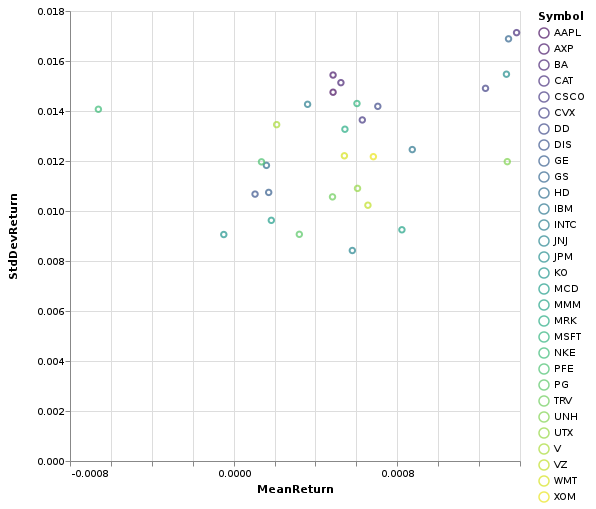

In [74]:
returnagg |>
    @vlplot(:point, x=:MeanReturn, y=:StdDevReturn, color={"Symbol:o", scale={scheme="viridis"}},
            width=450, height=450)

In [75]:
shiftedreturns = returns |>
    @join(returnagg, _.Symbol, _.Symbol, {_.Symbol, _.Date, ShiftedReturn=_.Return - __.MeanReturn})
shiftedreturns |> @take(3)

3x3 query result
Symbol │ Date       │ ShiftedReturn
───────┼────────────┼──────────────
AAPL   │ 2016-01-05 │ -0.0255454   
AAPL   │ 2016-01-06 │ -0.0200558   
AAPL   │ 2016-01-07 │ -0.0426907

In [78]:
correlation = shiftedreturns |>
    @join(shiftedreturns, _.Date, _.Date,
          {Left=_.Symbol, Right=__.Symbol, Product=_.ShiftedReturn * __.ShiftedReturn}) |>
    @groupby({_.Left, _.Right}) |>
    @map({Left=_.Left[1], Right=_.Right[1], Covariance=mean(_.Product)}) |>
    @join(returnagg, _.Left, _.Symbol, {_.Left, _.Right, _.Covariance, LeftStdDev=__.StdDevReturn}) |>
    @join(returnagg, _.Right, _.Symbol,
          {_.Left, _.Right, _.Covariance, Correlation=_.Covariance / (_.LeftStdDev * __.StdDevReturn)}) |>
    @map({_.Left, _.Right, _.Correlation, AbsCorrelation=abs(_.Correlation)})
correlation |> @take(3)

3x4 query result
Left │ Right │ Correlation │ AbsCorrelation
─────┼───────┼─────────────┼───────────────
AAPL │ AAPL  │ 0.996016    │ 0.996016      
AAPL │ AXP   │ 0.0778969   │ 0.0778969     
AAPL │ BA    │ 0.333564    │ 0.333564

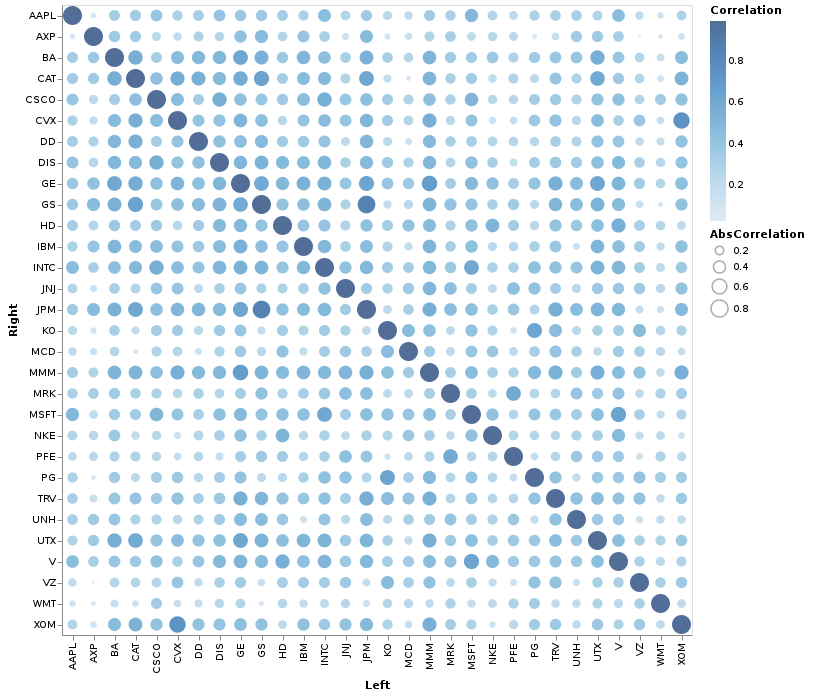

In [81]:
correlation |>
    @vlplot(:circle, x=:Left, y=:Right, size=:AbsCorrelation, color={"Correlation:q"})
#    color={"Correlation:q", scale={domain= [-1, 0, 1], range=["#ca0020","#f7f7f7","#0571b0"]}})

# Model for Picking Representatives